# **Machine Learning: Final Assigment - Re-take (revised product)**

**Revised product author:**

Florencia Cecilia Brazionis - ID 175974  


**First submission authors:**

Eleni Kalema: ID - 175891  
Lucia Argudin - ID 175893  

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline
from scipy.stats import uniform
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import gdown

In [2]:
# Download file from Google Drive
file_id = '1OMuIqQVbgDzGoOybqaGhj-iGWQZddwjB'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'AIML Dataset.csv'
gdown.download(url, output, quiet=False)

# Read the CSV into a pandas DataFrame
df = pd.read_csv(output)

# Display the first few rows
print(df.head())

Downloading...
From (original): https://drive.google.com/uc?id=1OMuIqQVbgDzGoOybqaGhj-iGWQZddwjB
From (redirected): https://drive.google.com/uc?id=1OMuIqQVbgDzGoOybqaGhj-iGWQZddwjB&confirm=t&uuid=fc89e312-397c-4b3c-bb0e-9262e64a4b3d
To: /content/AIML Dataset.csv
100%|██████████| 494M/494M [00:07<00:00, 64.4MB/s]


   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [3]:
# Check for missing values
print(df.isnull().sum())

# Check data types
print(df.dtypes)

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


In [4]:
# Drop unnecessary columns from the dataset
df = df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])

print(df.head())

   step      type    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   PAYMENT   9839.64       170136.0       160296.36             0.0   
1     1   PAYMENT   1864.28        21249.0        19384.72             0.0   
2     1  TRANSFER    181.00          181.0            0.00             0.0   
3     1  CASH_OUT    181.00          181.0            0.00         21182.0   
4     1   PAYMENT  11668.14        41554.0        29885.86             0.0   

   newbalanceDest  isFraud  
0             0.0        0  
1             0.0        0  
2             0.0        1  
3             0.0        1  
4             0.0        0  


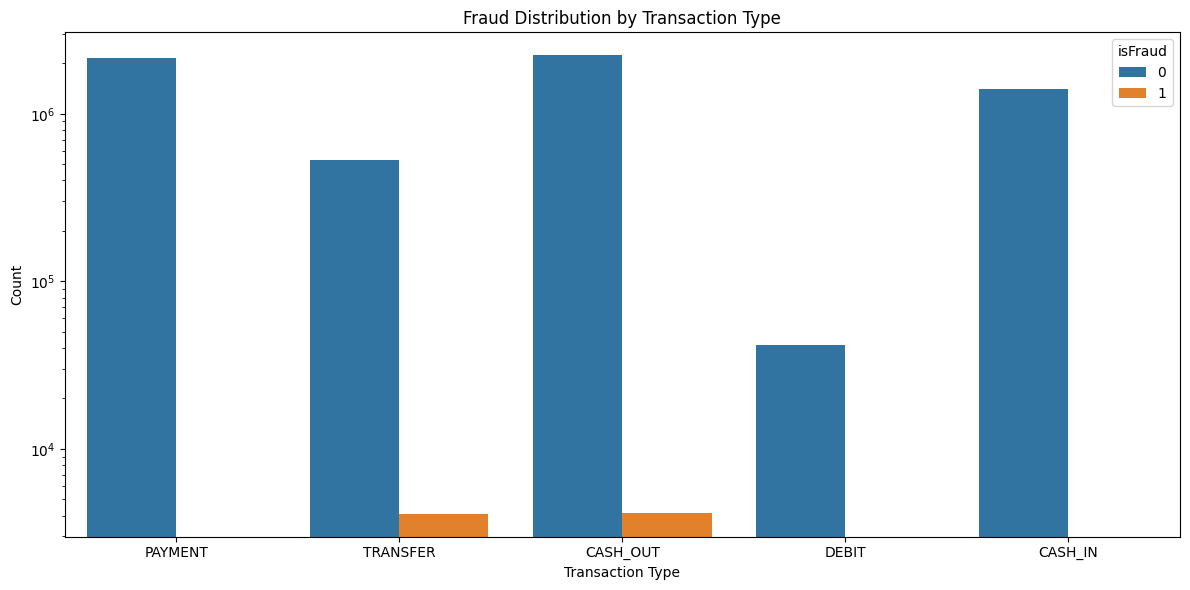

In [5]:
# Transaction type analysis visualization
plt.figure(figsize=(12, 6))
sns.countplot(x='type', hue='isFraud', data=df)
plt.title('Fraud Distribution by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.yscale('log')
plt.tight_layout()
plt.show()

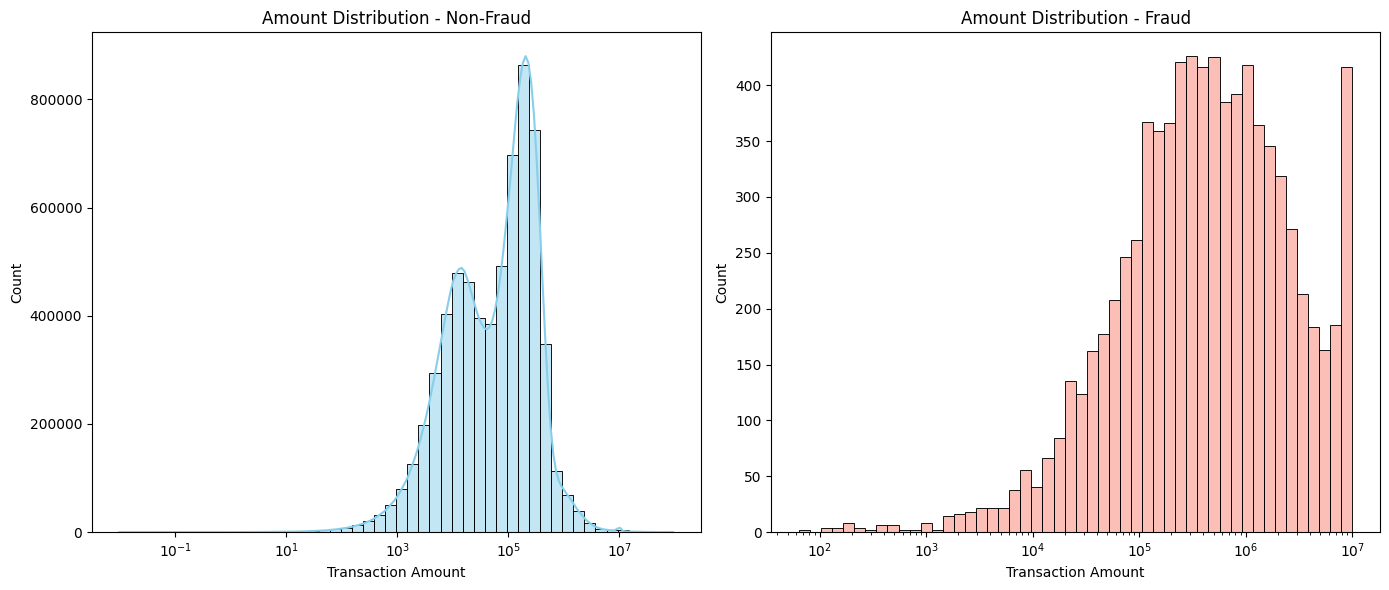

In [6]:
# Amount distribution for fraud vs non-fraud visualization
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df[df['isFraud']==0]['amount'], bins=50, kde=True, color='skyblue', log_scale=True)
plt.title('Amount Distribution - Non-Fraud')
plt.xlabel('Transaction Amount')
plt.xscale('log')

plt.subplot(1, 2, 2)
sns.histplot(df[df['isFraud']==1]['amount'], bins=50, kde=True, color='salmon', log_scale=True)
plt.title('Amount Distribution - Fraud')
plt.xlabel('Transaction Amount')
plt.xscale('log')

plt.tight_layout()
plt.show()

In [7]:
# Next we perform one-hot encode the 'type' column and drop it
df = pd.get_dummies(df, columns=['type'], drop_first=True)
print(df.head())

   step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   9839.64       170136.0       160296.36             0.0   
1     1   1864.28        21249.0        19384.72             0.0   
2     1    181.00          181.0            0.00             0.0   
3     1    181.00          181.0            0.00         21182.0   
4     1  11668.14        41554.0        29885.86             0.0   

   newbalanceDest  isFraud  type_CASH_OUT  type_DEBIT  type_PAYMENT  \
0             0.0        0          False       False          True   
1             0.0        0          False       False          True   
2             0.0        1          False       False         False   
3             0.0        1           True       False         False   
4             0.0        0          False       False          True   

   type_TRANSFER  
0          False  
1          False  
2           True  
3          False  
4          False  


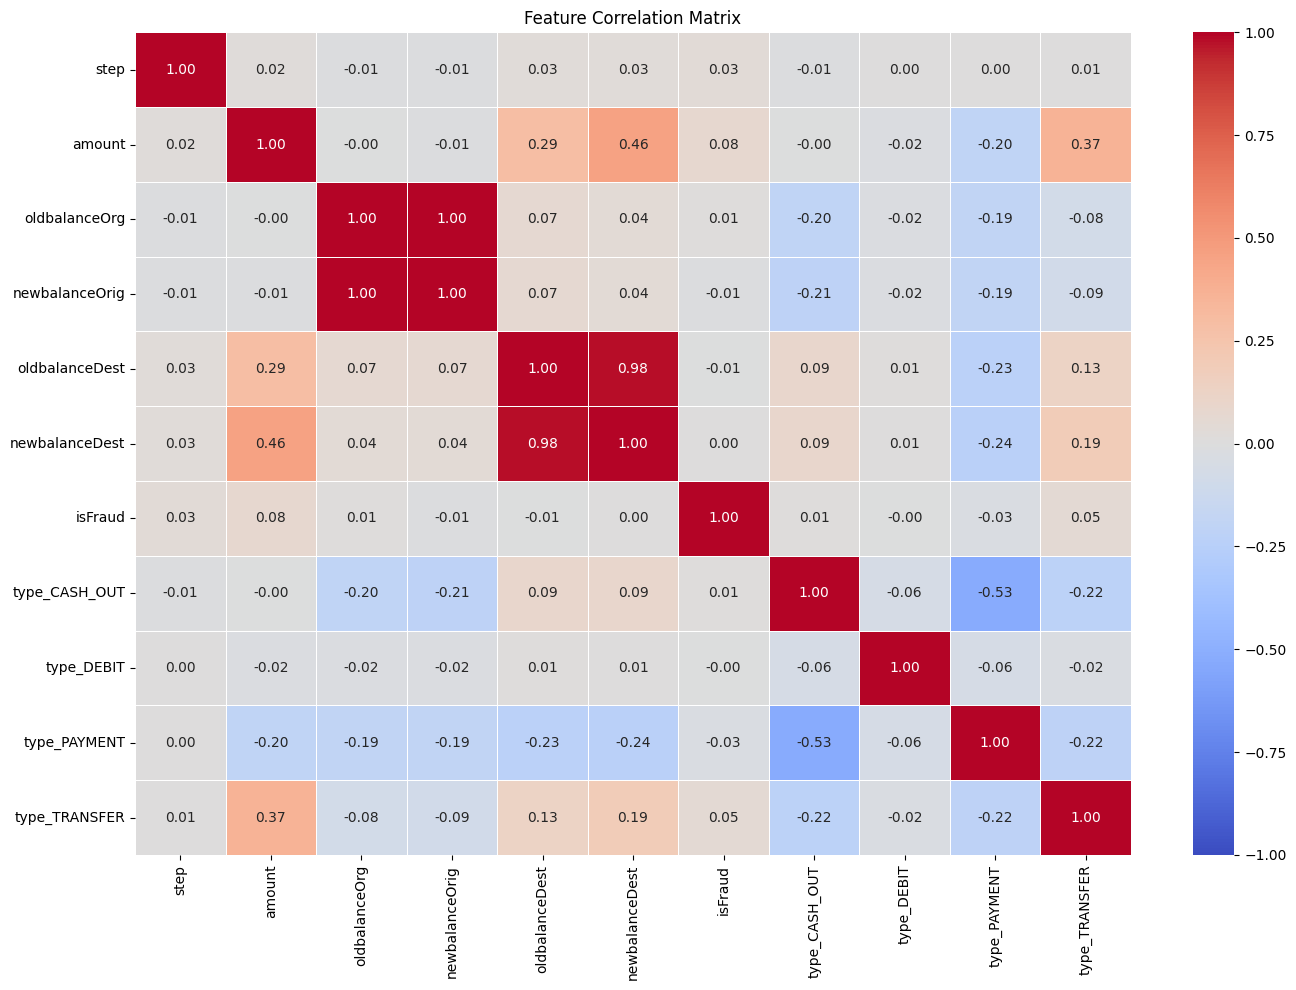

In [8]:
# Feature correlation matrix
correlation = df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

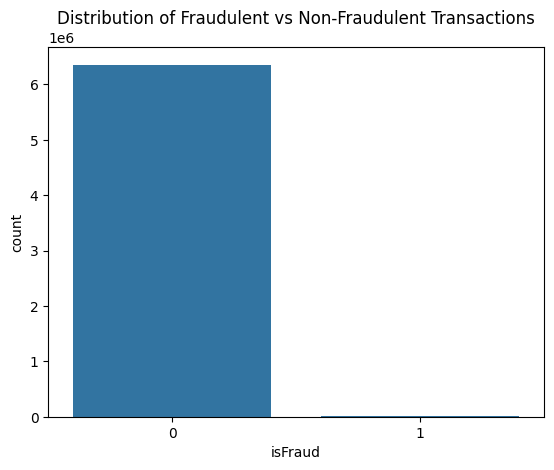

Percentage of fraudulent transactions: 0.13%
Number of fraudulent transactions: 8213


In [9]:
# Taking 'isFraud' as the target column
sns.countplot(x='isFraud', data=df)
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.show()

# Next we calculate the percentage of fraudulent transactions
fraud_percentage = df['isFraud'].mean() * 100
fraud_count = (df['isFraud'] == 1).sum()
print(f"Percentage of fraudulent transactions: {fraud_percentage:.2f}%")
print(f"Number of fraudulent transactions: {fraud_count}")


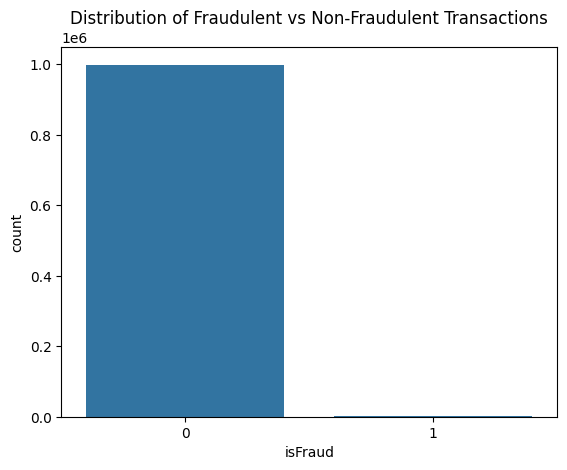

Percentage of fraudulent transactions: 0.1291%
Number of fraudulent transactions: 1291


In [10]:
# Stratifying random sample of 1,000,000 rows using train_test_split function for keeping the class balance
df, _ = train_test_split(
    df,
    train_size=1_000_000,
    stratify=df['isFraud'],
    random_state=42
)

# Assuming 'isFraud' is the target column
sns.countplot(x='isFraud', data=df)
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.show()

# Calculate the percentage of fraudulent transactions
fraud_percentage = df['isFraud'].mean() * 100
fraud_count = (df['isFraud'] == 1).sum()
print(f"Percentage of fraudulent transactions: {fraud_percentage:.4f}%")
print(f"Number of fraudulent transactions: {fraud_count}")

In [11]:
#Checking row count after we cut the dataset
print(df.count())

step              1000000
amount            1000000
oldbalanceOrg     1000000
newbalanceOrig    1000000
oldbalanceDest    1000000
newbalanceDest    1000000
isFraud           1000000
type_CASH_OUT     1000000
type_DEBIT        1000000
type_PAYMENT      1000000
type_TRANSFER     1000000
dtype: int64


In [12]:
#Separating target variable 'isFraud'
target_var = df['isFraud']
target_var

,isFraud
3640776,0
3127218,0
4752380,0
6356543,0
3902308,0
...,...
3832448,0
2503277,0
2396238,0
1541412,0


In [13]:
#Dropping the 'isFraud' column of our dataset as it is the variable we want to predict
df.drop('isFraud', axis=1, inplace=True)
print(df.head())

         step     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
3640776   275   21226.31            0.0            0.00            0.00   
3127218   236     660.62        75109.0        74448.38      1286830.01   
4752380   333   42651.87       132304.0       174955.87            0.00   
6356543   710  367509.16        39438.0       406947.16            0.00   
3902308   284  115672.77        40243.0            0.00      2068662.71   

         newbalanceDest  type_CASH_OUT  type_DEBIT  type_PAYMENT  \
3640776            0.00          False       False          True   
3127218      1287490.64           True       False         False   
4752380            0.00          False       False         False   
6356543            0.00          False       False         False   
3902308      2184335.48           True       False         False   

         type_TRANSFER  
3640776          False  
3127218          False  
4752380          False  
6356543          False  
3902308        

In [14]:
# Next we proceed to splitting the data in training, validation and test set

def split_data(X, y, train_size=0.6, val_size=0.2, test_size=0.2, random_state=42):

    assert train_size + val_size + test_size == 1.0

    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    val_relative_size = val_size / (train_size + val_size)

    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_relative_size, stratify=y_temp, random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

X = df
y = target_var

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, train_size=0.6, val_size=0.2, test_size=0.2)

Logistic Regression Model Tuning

In [ ]:
# Define parameter distributions
param_distributions = {
    'C': uniform(loc=0.01, scale=10),  # we set a continuous range from 0.01 to 10
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': ['balanced'], # We force it to be balanced
    'max_iter': [500, 1000]
}

# Initialize Logistic Regression
lr = LogisticRegression(random_state=42)


# Set up RandomizedSearchCV
# We select f1 as score to help focus on the minority class considering precision and recall
random_search = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_distributions,
    n_iter=20,             # number of random combinations to try
    scoring='f1',          # optimize for F1-score
    cv=5,                  # 5-fold cross-validation
    verbose=2,             # show progress
    n_jobs=-1,             # use all cores
    random_state=42        # reproducibility
)

# Run randomized search on the training data
random_search.fit(X_train, y_train)

# Get best model from the random search
best_model = random_search.best_estimator_

#Lasted 9 minutes and 17 seconds.

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[CV] END C=3.7554011884736247, class_weight=balanced, max_iter=500, solver=lbfgs; total time=   6.7s
[CV] END C=3.7554011884736247, class_weight=balanced, max_iter=500, solver=lbfgs; total time=   6.8s
[CV] END C=3.7554011884736247, class_weight=balanced, max_iter=500, solver=lbfgs; total time=   7.2s
[CV] END C=3.7554011884736247, class_weight=balanced, max_iter=500, solver=lbfgs; total time=  13.2s
[CV] END C=7.3299394181140505, class_weight=balanced, max_iter=500, solver=lbfgs; total time=   6.3s
[CV] END C=7.3299394181140505, class_weight=balanced, max_iter=500, solver=lbfgs; total time=   6.4s
[CV] END C=7.3299394181140505, class_weight=balanced, max_iter=500, solver=lbfgs; total time=   7.3s
[CV] END C=7.3299394181140505, class_weight=balanced, max_iter=500, solver=lbfgs; total time=  15.3s
[CV] END C=3.7554011884736247, class_weight=balanced, max_iter=500, solver=lbfgs; total time=  19.1s
[CV] END C=7.3299394181140505, class_weight=balanced, max_iter=500, solver=lbfgs; total tim

In [ ]:
print("Best parameters from RandomSearch:", random_search.best_params_)
print("Best F1 score from RS:", random_search.best_score_)


Best parameters from RandomSearch: {'C': np.float64(6.021150117432088), 'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'lbfgs'}
Best F1 score from RS: 0.05719214231803982


In [ ]:
# Defining hyperparameter for GridSearchCV taking into account the results from RandomSearch
param_grid = {
    'C': [1.0, 3.0, 4.0, 6, 6.5, 7],  # Discrete values instead of a distribution
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': ['balanced'],
    'max_iter': [500, 1000]
}


# GridSearchCV tries every combination of hyperparameters in param_grid and scores each one based on F1-score.
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best parameters from GridSearchCV:", grid_search.best_params_)
print("Best F1 score from CV:", grid_search.best_score_)

#10 minutes and 11 seconds

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END C=1.0, class_weight=balanced, max_iter=500, solver=lbfgs; total time=   5.9s
[CV] END C=1.0, class_weight=balanced, max_iter=500, solver=lbfgs; total time=   8.6s
[CV] END C=1.0, class_weight=balanced, max_iter=500, solver=lbfgs; total time=  11.6s
[CV] END C=1.0, class_weight=balanced, max_iter=500, solver=lbfgs; total time=  12.4s
[CV] END C=1.0, class_weight=balanced, max_iter=500, solver=lbfgs; total time=   7.2s
[CV] END C=1.0, class_weight=balanced, max_iter=500, solver=liblinear; total time=   6.6s


[CV] END C=1.0, class_weight=balanced, max_iter=500, solver=liblinear; total time=  11.4s
[CV] END C=1.0, class_weight=balanced, max_iter=500, solver=liblinear; total time=  16.6s
[CV] END C=1.0, class_weight=balanced, max_iter=500, solver=liblinear; total time=  14.1s
[CV] END C=1.0, class_weight=balanced, max_iter=500, solver=liblinear; total time=   8.9s
[CV] END C=1.0, class_weight=balanced, max_iter=1000, solver=lbfgs; total time=   5.8s
[CV] END C=1.0, class_weight=balanced, max_iter=1000, solver=lbfgs; total time=   8.6s
[CV] END C=1.0, class_weight=balanced, max_iter=1000, solver=lbfgs; total time=  13.5s
[CV] END C=1.0, class_weight=balanced, max_iter=1000, solver=lbfgs; total time=   7.0s
[CV] END C=1.0, class_weight=balanced, max_iter=1000, solver=lbfgs; total time=  12.1s
[CV] END C=1.0, class_weight=balanced, max_iter=1000, solver=liblinear; total time=   6.6s
[CV] END C=1.0, class_weight=balanced, max_iter=1000, solver=liblinear; total time=  16.2s
[CV] END C=1.0, class_w

In [ ]:
# Training predictions on Logistic Regression
y_train_pred = best_model.predict(X_train)
print("Training Set Report - Logistic Regression:\n", classification_report(y_train, y_train_pred))

Training Set Report - Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98    599225
           1       0.03      0.96      0.05       775

    accuracy                           0.95    600000
   macro avg       0.51      0.95      0.51    600000
weighted avg       1.00      0.95      0.97    600000



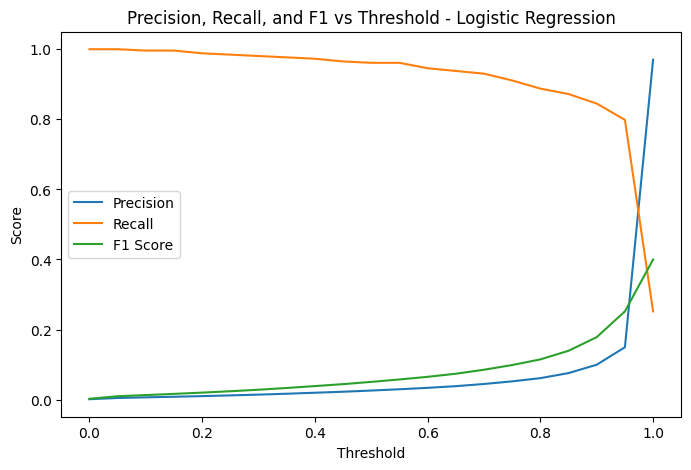

 Threshold | Precision | Recall |  F1 Score
----------------------------------------
      0.00 |     0.001 |  1.000 |     0.003
      0.05 |     0.005 |  1.000 |     0.010
      0.10 |     0.007 |  0.996 |     0.013
      0.15 |     0.008 |  0.996 |     0.017
      0.20 |     0.010 |  0.988 |     0.020
      0.25 |     0.012 |  0.984 |     0.024
      0.30 |     0.014 |  0.981 |     0.028
      0.35 |     0.017 |  0.977 |     0.033
      0.40 |     0.020 |  0.973 |     0.039
      0.45 |     0.023 |  0.965 |     0.044
      0.50 |     0.026 |  0.961 |     0.051
      0.55 |     0.030 |  0.961 |     0.058
      0.60 |     0.034 |  0.946 |     0.065
      0.65 |     0.039 |  0.938 |     0.074
      0.70 |     0.045 |  0.930 |     0.085
      0.75 |     0.052 |  0.911 |     0.099
      0.80 |     0.061 |  0.888 |     0.115
      0.85 |     0.076 |  0.872 |     0.140
      0.90 |     0.100 |  0.845 |     0.178
      0.95 |     0.150 |  0.798 |     0.252
      1.00 |     0.970 |  0.252 |  

In [ ]:

# Predict probabilities for the validation set
y_val_proba = best_model.predict_proba(X_val)[:, 1]

# Define thresholds to test (from 0.0 to 1.0 in steps of 0.05)
thresholds_to_test = np.arange(0.0, 1.05, 0.05)

# Store metrics
precision_list = []
recall_list = []
f1_list = []

# Loop through thresholds
for threshold in thresholds_to_test:
    y_pred = (y_val_proba >= threshold).astype(int)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# Plot precision, recall, and F1 vs threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds_to_test, precision_list, label='Precision')
plt.plot(thresholds_to_test, recall_list, label='Recall')
plt.plot(thresholds_to_test, f1_list, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs Threshold - Logistic Regression')
plt.legend()
plt.show()

# Print a table of results
print(f"{'Threshold':>10} | {'Precision':>9} | {'Recall':>6} | {'F1 Score':>9}")
print("-" * 40)
for t, p, r, f in zip(thresholds_to_test, precision_list, recall_list, f1_list):
    print(f"{t:10.2f} | {p:9.3f} | {r:6.3f} | {f:9.3f}")


In [ ]:
# Get predicted probabilities on validation set
y_val_proba = best_model.predict_proba(X_val)[:, 1]

# Get precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

# Now we set minimum acceptable precision
min_precision = 0.5

# Filter for thresholds where precision >= min_precision
valid_idxs = np.where(precision >= min_precision)[0]

if len(valid_idxs) > 0:
    # Pick the index with the highest recall among those
    best_idx = valid_idxs[np.argmax(recall[valid_idxs])]
    best_threshold = thresholds[best_idx]
    best_precision = precision[best_idx]
    best_recall = recall[best_idx]
    print(f"Best threshold (precision ≥ {min_precision}): {best_threshold:.4f}")
    print(f"Precision: {best_precision:.4f}, Recall: {best_recall:.4f}")
else:
    print(f"No thresholds found with precision ≥ {min_precision}. Consider lowering your precision requirement.")


Best threshold (precision ≥ 0.5): 0.9986
Precision: 0.5000, Recall: 0.6550


In [ ]:
# Validation predictions on Logistic Regression
y_val_pred = best_model.predict(X_val)
print("Validation Set Report - Logistic Regression:\n", classification_report(y_val, y_val_pred))

Validation Set Report - Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98    199742
           1       0.03      0.96      0.05       258

    accuracy                           0.95    200000
   macro avg       0.51      0.96      0.51    200000
weighted avg       1.00      0.95      0.98    200000



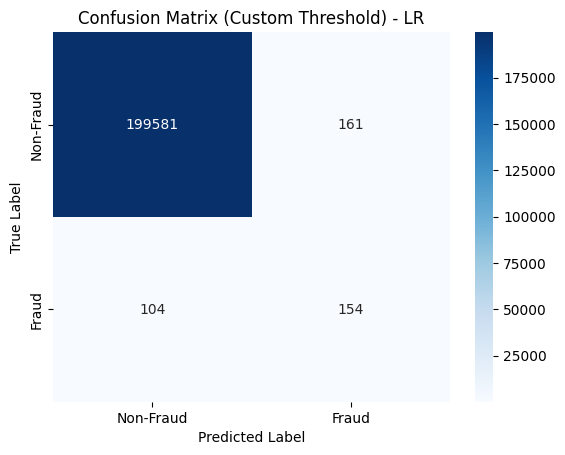

Best threshold: 0.9986
Test Set Classification Report - LR:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199742
           1       0.49      0.60      0.54       258

    accuracy                           1.00    200000
   macro avg       0.74      0.80      0.77    200000
weighted avg       1.00      1.00      1.00    200000



In [ ]:
# Evaluate on test set using best custom threshold
# Get predicted probabilities from best logistic regression model
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Apply the optimal threshold to convert probabilities to binary predictions
y_test_pred_custom = (y_test_proba >= best_threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_custom)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Custom Threshold) - LR")
plt.show()

# Print best threshold used
print(f"Best threshold: {best_threshold:.4f}")

# Test set predictions on Logistic Regression
print("Test Set Classification Report - LR:\n", classification_report(y_test, y_test_pred_custom))


In [ ]:
# Get model coefficients
coefficients = best_model.coef_[0]

# Get absolute values to reflect importance for example magnitude, regardless of sign
importances = np.abs(coefficients)

# Assuming X_train is a dataframe
features = X_train.columns

# Creating a dataframe
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Show top 10
print(importance_df.head(10))

          Feature    Importance
8    type_PAYMENT  5.634651e+00
9   type_TRANSFER  3.135613e+00
6   type_CASH_OUT  1.021383e+00
7      type_DEBIT  1.818787e-01
0            step  3.104880e-03
3  newbalanceOrig  2.882988e-05
2   oldbalanceOrg  2.857684e-05
5  newbalanceDest  1.438663e-05
4  oldbalanceDest  1.420725e-05
1          amount  3.953885e-08


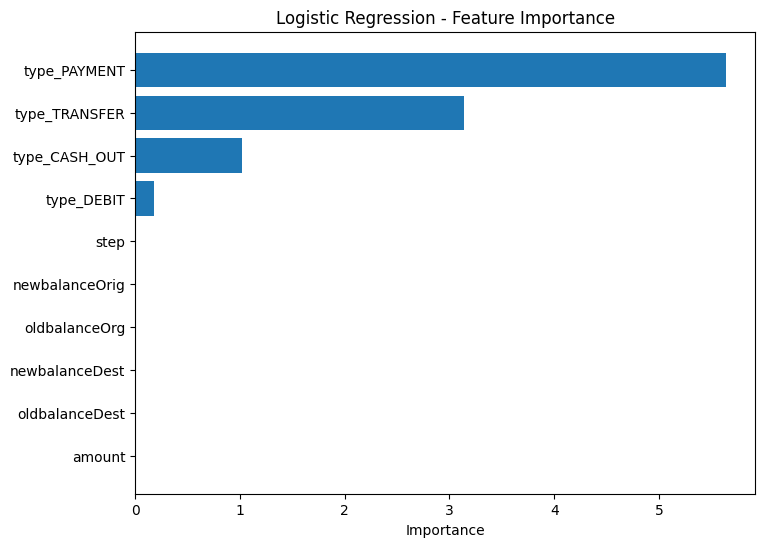

In [ ]:
# Plot top 10 features
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'][:15][::-1], importance_df['Importance'][:10][::-1])
plt.xlabel('Importance')
plt.title('Logistic Regression - Feature Importance')
plt.show()

Random Forest Model Tuning

In [ ]:
rf = RandomForestClassifier(class_weight='balanced',random_state=42)
# we define param_grid: dictionary of parameters we want to try.
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1],
    'max_features': ['sqrt', 'log2']
}


# best_model:After training, this is the best-performing Random Forest
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1',
    cv=3,          # let it split internally. 3 cross.vallidation within the training set, Model is trained 3 times, each with a different validation fold, and the final score is the average over these 3 runs
    n_jobs=-1,
    refit=True,
    verbose = 1, #We add this to check how much time each iteration takes
)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

#38 minutes and 54 s

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [ ]:
# Training predictions on Random Forest
y_train_pred = best_model.predict(X_train)
print("Training Set Report - Random Forest:\n", classification_report(y_train, y_train_pred))

Training Set Report - Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    599225
           1       1.00      1.00      1.00       775

    accuracy                           1.00    600000
   macro avg       1.00      1.00      1.00    600000
weighted avg       1.00      1.00      1.00    600000



In [ ]:
print("Best hyperparameters:", grid.best_params_)
print("Best F1-score (cross-validated):", grid.best_score_)

Best hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best F1-score (cross-validated): 0.832273130307772


In [ ]:
# predict_proba: Returns fraud probability for each validation point.
# precision_recall_curve: Evaluates model at all possible thresholds (not just 0.5)
# f1_scores: We calculate F1 at each threshold
# best_threshold: Chooses the threshold that gives highest F1-score
y_val_proba = best_model.predict_proba(X_val)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]
best_threshold

np.float64(0.46899884133895875)

In [ ]:
# Validation predictions on Random Forest
y_val_pred = (y_val_proba >= best_threshold).astype(int) # convert probabilities to class labels using custom threshold
print("Validation Set Report - Random Forest:\n", classification_report(y_val, y_val_pred))

Validation Set Report - Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199742
           1       0.96      0.81      0.88       258

    accuracy                           1.00    200000
   macro avg       0.98      0.91      0.94    200000
weighted avg       1.00      1.00      1.00    200000



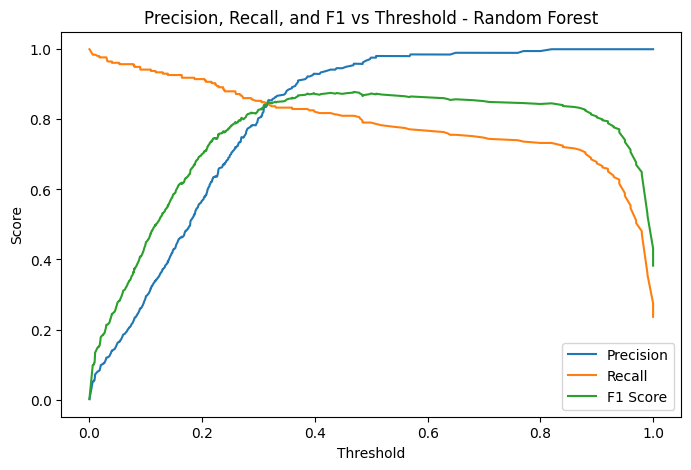

In [ ]:

# Compute F1 scores (with slicing to match threshold length)
precision = precision[:-1]
recall = recall[:-1]
f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

# Plot threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.plot(thresholds, f1, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs Threshold - Random Forest')
plt.legend()
plt.show()


In [ ]:
f1_val = f1_score(y_val, (y_val_proba >= best_threshold).astype(int))
print("Validation F1:", f1_val) #0.5185185185185185

Validation F1: 0.8781512605042017


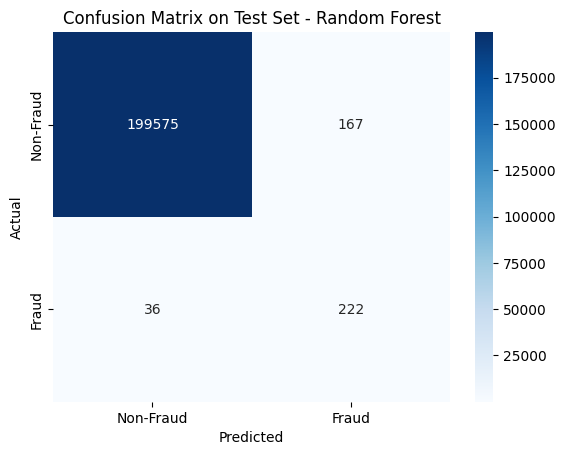

Best threshold considering F1: 0.46899884133895875
Chosen threshold prioritizing recall: 0.2
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199742
           1       0.57      0.86      0.69       258

    accuracy                           1.00    200000
   macro avg       0.79      0.93      0.84    200000
weighted avg       1.00      1.00      1.00    200000



In [ ]:
manual_threshold = 0.2 #Threshold that prioritizes recall
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred_custom = (y_test_proba >= manual_threshold).astype(int)

cm = confusion_matrix(y_test, y_test_pred_custom)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set - Random Forest")
plt.show()

print("Best threshold considering F1:", best_threshold)
print("Chosen threshold prioritizing recall:", manual_threshold)
print("Classification Report:\n", classification_report(y_test, y_test_pred_custom))


In [ ]:
# Assuming X has column names (features)
feature_importances = pd.Series(best_model.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

print("Top contributing features:")
print(top_features)

Top contributing features:
oldbalanceOrg     0.285292
amount            0.164636
newbalanceOrig    0.155529
type_TRANSFER     0.101146
step              0.070109
newbalanceDest    0.068656
type_CASH_OUT     0.059024
type_PAYMENT      0.049319
oldbalanceDest    0.046176
type_DEBIT        0.000114
dtype: float64


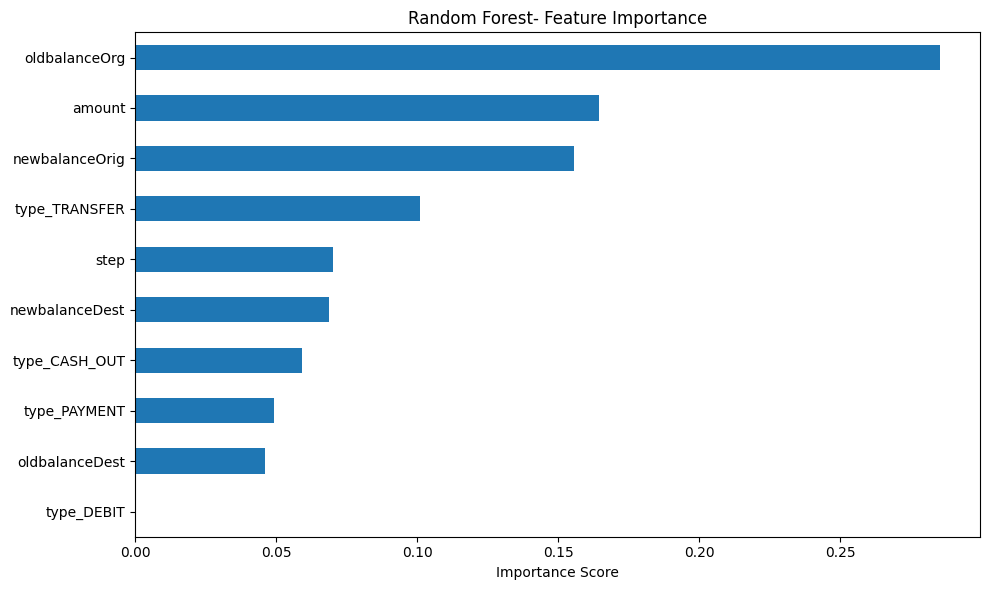

In [ ]:
top_features.plot(kind='barh', figsize=(10, 6))
plt.gca().invert_yaxis()
plt.title("Random Forest- Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

XGBoost model tuning

In [ ]:
#Defining xgboost model

num_pos = np.sum(y_train == 1)
num_neg = np.sum(y_train == 0)

# Compute scale_pos_weight
ratio = num_neg / num_pos
print(f"scale_pos_weight: {ratio:.2f}")

scale_pos_weight: 773.19


In [ ]:
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=ratio,
    eval_metric='logloss',
    random_state=42
)

#define hyperparameter
param_dist = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [ratio, ratio*0.5, ratio*2],
    'gamma': [0, 1, 5],              # min loss reduction to split
    'reg_alpha': [0, 0.1, 1],        # L1 regularization
    'reg_lambda': [1, 1.5]           # L2 regularization
}


In [ ]:
#run RandomizedSearch
"""
We choose RandmomizedSearchCV instead of GridSearchCV because it is way more cost and time efficient as it uses
random sampling on the combinations of the hyperparameters instead of going through every single one.
"""
search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,    #20 iterations
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42
)

search.fit(X_train, y_train)

#1 min 27
#2 minutes and 52 seconds

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [1, 1.5],
                                        'scale_pos_weight': [np.float64(773.1935483870968),
                                                             np.float64(386.5967741935484),
                                                             np.float64(1546.3870967741937)],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='f1', verbose=1)

In [ ]:
print(search.best_params_['scale_pos_weight'])


1546.3870967741937


In [ ]:

#adjusting the parameter to new settings based on the previous results and running GridSearch to choose the best result
param_grid = {
    'max_depth': [5, 7],
    'scale_pos_weight': [1546.3870967741937],
    'learning_rate': [0.1, 0.13],
    'n_estimators': [300, 400],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1.5]
}

search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs = -1
)

search.fit(X_train, y_train)

#11 minutes and 10
#before was 20' and 49


Fitting 3 folds for each of 128 candidates, totalling 384 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 1],
                         'learning_rate': [0.1, 0.13], 'max_depth': [5, 7],
                         'n_estimators': [300, 400], 'reg_alpha': [0, 0.1],
                         'reg_lambda': [1.5],
                         'scale_pos_weight': [1546.3870967741937],
                         'subsample': [0.7, 0.8]},
             scoring='f1', verbose=1)

In [ ]:
# Check best parameter and evaluate model
print("Best Parameters:\n", search.best_params_)

best_model = search.best_estimator_

# Training predictions on XGBoost
y_train_pred = best_model.predict(X_train)
print("Training Set Report:\n", classification_report(y_train, y_train_pred))



Best Parameters:
 {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.13, 'max_depth': 7, 'n_estimators': 400, 'reg_alpha': 0, 'reg_lambda': 1.5, 'scale_pos_weight': 1546.3870967741937, 'subsample': 0.7}
Training Set Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    599225
           1       0.99      1.00      1.00       775

    accuracy                           1.00    600000
   macro avg       1.00      1.00      1.00    600000
weighted avg       1.00      1.00      1.00    600000



Validation Set Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199742
           1       0.82      0.90      0.86       258

    accuracy                           1.00    200000
   macro avg       0.91      0.95      0.93    200000
weighted avg       1.00      1.00      1.00    200000



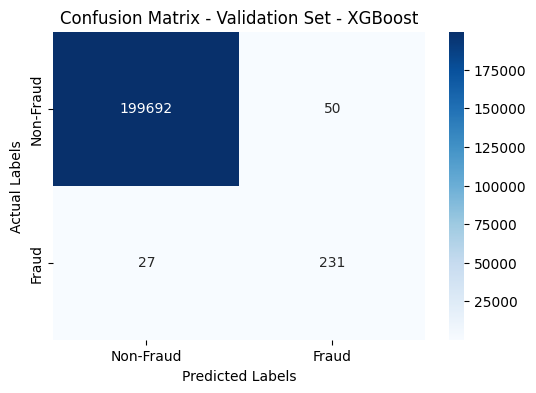

In [ ]:
y_val_pred = best_model.predict(X_val)

# Evaluate on validation set
print("Validation Set Evaluation")
print(classification_report(y_val, y_val_pred))

# Compute confusion matrix for validation predictions
cm_val = confusion_matrix(y_val, y_val_pred)

# Plot on validation data
plt.figure(figsize=(6,4))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Validation Set - XGBoost')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

In [ ]:
# Applying same code as random forest to find threshold for highest f1 score
y_val_probs_xg = best_model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_val_probs_xg)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best threshold for F1 (val):", best_threshold)

Best threshold for F1 (val): 0.9376712


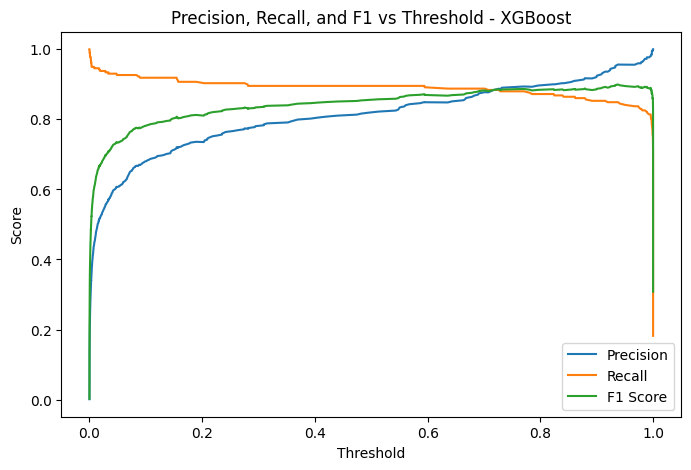

In [ ]:
# Compute F1 scores (with slicing to match threshold length)
precision = precision[:-1]
recall = recall[:-1]
f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.plot(thresholds, f1, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs Threshold - XGBoost')
plt.legend()
plt.show()

In [ ]:
# Choose a threshold (example: from validation tuning)
custom_threshold = 0.2  # or your best_thr from val

# Get probabilities for the positive class
y_val_proba = best_model.predict_proba(X_val)[:, 1]

# Apply your custom threshold
y_val_pred_custom = (y_val_proba >= custom_threshold).astype(int)

# Evaluate
print("Val Set Report with custom threshold:\n", custom_threshold,
      classification_report(y_val, y_val_pred_custom))

# Compute confusion matrix for validation predictions
cm_val = confusion_matrix(y_val, y_val_pred_custom)

Val Set Report with custom threshold:
 0.2               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199742
           1       0.74      0.90      0.81       258

    accuracy                           1.00    200000
   macro avg       0.87      0.95      0.91    200000
weighted avg       1.00      1.00      1.00    200000



In [ ]:
# Train final model with the best parameters

xgb_model = xgb.XGBClassifier(
    scale_pos_weight= 1546.3870967741937,
    eval_metric='logloss',
    colsample_bytree = 0.8,
    gamma = 0,
    learning_rate = 0.13,
    max_depth = 7,
    n_estimators = 400,
    reg_alpha = 0,
    reg_lambda = 1.5,
    subsample = 0.7,
    random_state=42
)

final_model = xgb_model.fit(X_train, y_train)

# Predict on the test sets
y_test_pred_xg = final_model.predict(X_test)



Test Set Evaluation with Threshold for higher Recall = 0.2
Best threshold for F1 score = 0.9376712

Test Set Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199742
           1       0.72      0.91      0.80       258

    accuracy                           1.00    200000
   macro avg       0.86      0.95      0.90    200000
weighted avg       1.00      1.00      1.00    200000



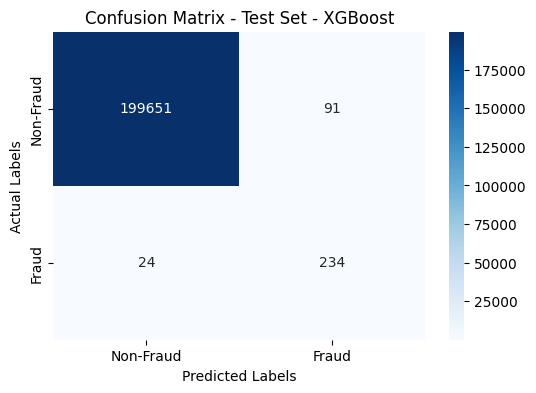

In [ ]:
# Set custom threshold
custom_thres = 0.2
y_test_proba_xg = final_model.predict_proba(X_test)[:, 1]
y_test_pred_xg  = (y_test_proba_xg >= custom_thres).astype(int)

# Evaluate on test set
print("Test Set Evaluation with Threshold for higher Recall =", custom_thres)
print("Best threshold for F1 score =", best_threshold)
print("\nTest Set Evaluation")
print(classification_report(y_test, y_test_pred_xg))
cm_test = confusion_matrix(y_test, y_test_pred_xg)
plt.figure(figsize=(6,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Test Set - XGBoost')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

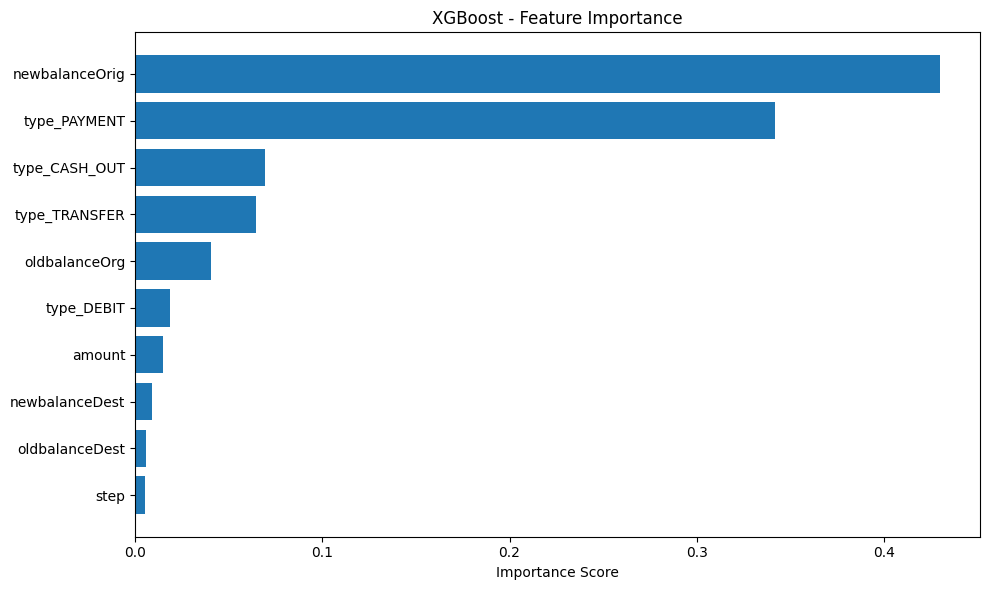

In [ ]:
# Get feature importances from the model
importances = best_model.feature_importances_

# Get feature names
feature_names = X_train.columns

# Combine into a DataFrame for easier plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('XGBoost - Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

Deep Learning MLP

Class Weights: {0: np.float64(0.500646668613626), 1: np.float64(387.0967741935484)}
Epoch 1/50
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - loss: 0.2616 - pr_auc: 0.1104 - precision: 0.0246 - recall: 0.5451 - val_loss: 0.0436 - val_pr_auc: 0.5187 - val_precision: 0.1095 - val_recall: 0.6589
Epoch 2/50
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 0.1476 - pr_auc: 0.3819 - precision: 0.0630 - recall: 0.7109 - val_loss: 0.0604 - val_pr_auc: 0.6680 - val_precision: 0.0493 - val_recall: 0.8372
Epoch 3/50
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - loss: 0.1282 - pr_auc: 0.4573 - precision: 0.0677 - recall: 0.7375 - val_loss: 0.0483 - val_pr_auc: 0.7258 - val_precision: 0.2073 - val_recall: 0.7946
Epoch 4/50
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.1070 - pr_auc: 0.5412 - precision: 0.0934 - recall: 0.7822 - val_loss: 0.0641 - val_pr_auc: 0.7386 - val_precision: 0.1133 - val_recall: 0.8295
Epoch 5/50
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - loss: 0.1125 - pr_

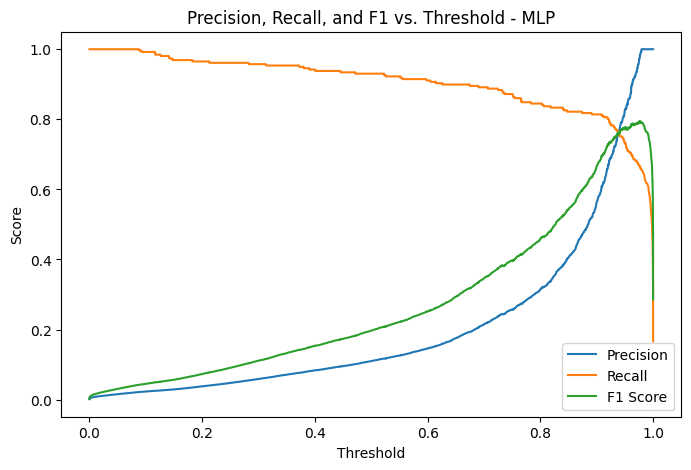

In [ ]:
# Preprocess features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Class weights to handle imbalance
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {0: class_weights_array[0], 1: class_weights_array[1]}
print("Class Weights:", class_weights)

# MLP model
model = Sequential([
    Dense(256, activation='relu'), # First hidden layer with 256 units
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),  # Second hidden layer
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'), # Third hidden layer
    Dropout(0.2),
    Dense(1, activation='sigmoid') # Output layer with sigmoid activation for binary classification
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)


model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='pr_auc', curve='PR')
    ]
)

# Early stopping
early_stop = EarlyStopping(monitor='val_pr_auc', patience=10, mode='max', restore_best_weights=True)

# Train the model using class weights
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=256,
    class_weight={0: 1, 1: 100},
    callbacks=[early_stop],
    verbose=1
)

# Predict probabilities and evaluate thresholds
y_val_proba = model.predict(X_val_scaled).flatten()
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)

# Plot precision, recall, and F1 vs threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.title('Precision, Recall, and F1 vs. Threshold - MLP')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()


18750/18750 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step
Training Set Performance:
Classification Report - Training Set - MLP
              precision    recall  f1-score   support

           0     0.9997    0.9994    0.9995    599225
           1     0.6084    0.7458    0.6701       775

    accuracy                         0.9991    600000
   macro avg     0.8040    0.8726    0.8348    600000
weighted avg     0.9992    0.9991    0.9991    600000



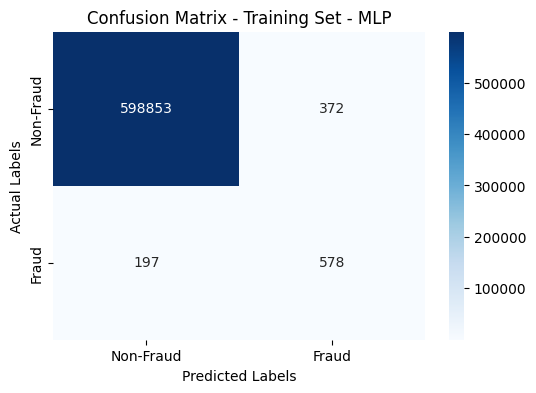

In [ ]:
# Predict on training set
manual_threshold = 0.9 #we choose this after looking at the plot
y_train_proba = model.predict(X_train_scaled)
y_train_pred = (y_train_proba >= manual_threshold).astype(int)

# Evaluate on training set
print("Training Set Performance:")
print('Classification Report - Training Set - MLP')
print(classification_report(y_train, y_train_pred, digits=4))

#Plot confusion matrix training set
cm = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Training Set - MLP')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()


Classification report - Validation Set MLP
              precision    recall  f1-score   support

           0     0.9999    0.9903    0.9951    199742
           1     0.1100    0.9302    0.1968       258

    accuracy                         0.9902    200000
   macro avg     0.5550    0.9603    0.5959    200000
weighted avg     0.9988    0.9902    0.9940    200000



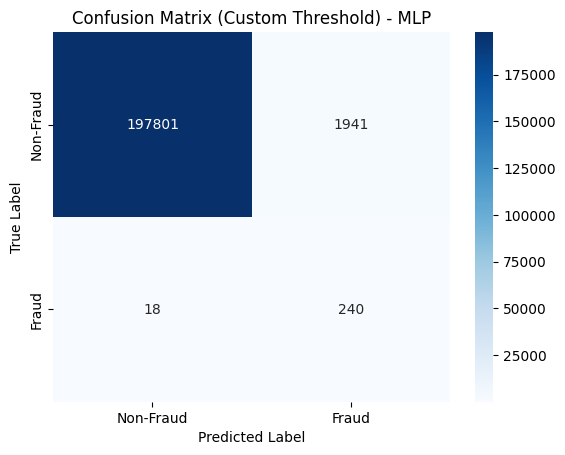

In [ ]:

manual_threshold = 0.5 # We choose this for higher recall
y_val_pred = (y_val_proba >= manual_threshold).astype(int)
print('Classification report - Validation Set MLP')
print(classification_report(y_val, y_val_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Custom Threshold) - MLP")
plt.show()



Test on the test set

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Test Set Performance:
              precision    recall  f1-score   support

           0     0.9999    0.9898    0.9948    199742
           1     0.1010    0.8876    0.1814       258

    accuracy                         0.9897    200000
   macro avg     0.5504    0.9387    0.5881    200000
weighted avg     0.9987    0.9897    0.9938    200000



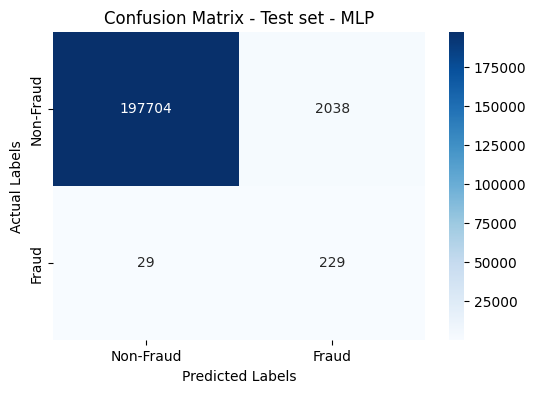

In [ ]:
# Predict on test set
manual_threshold = 0.5 #for even higher recall
y_test_proba = model.predict(X_test_scaled)
y_test_pred = (y_test_proba >= manual_threshold).astype(int)

# Evaluate
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred, digits=4))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Test set - MLP')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()


Research question 2

   1/6250 ━━━━━━━━━━━━━━━━━━━━ 3:08 30ms/step

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


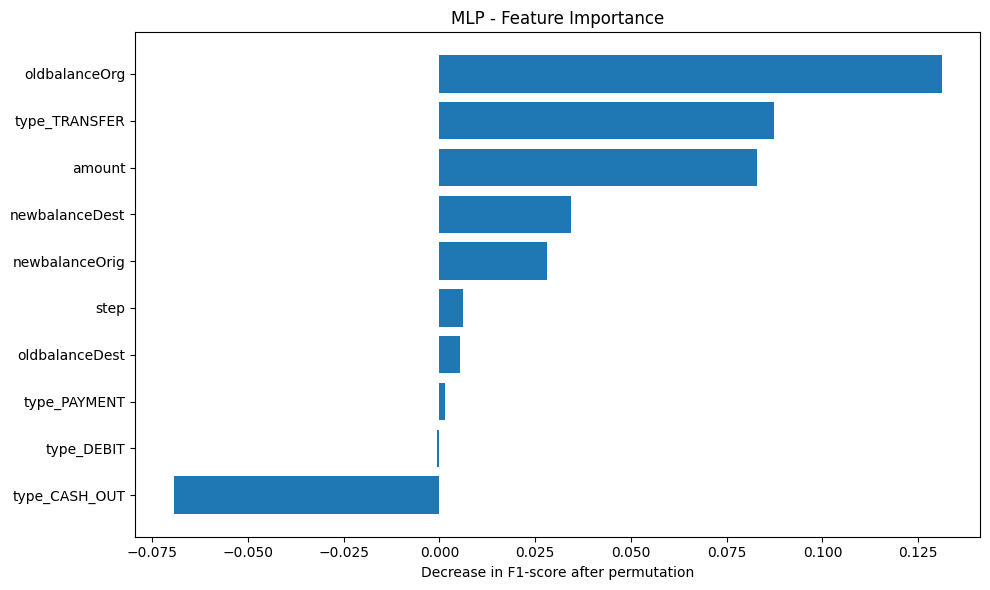

In [ ]:
# Get baseline F1-score on validation set
y_val_pred_baseline = (model.predict(X_val_scaled).flatten() >= 0.5).astype(int)
baseline_f1 = f1_score(y_val, y_val_pred_baseline)

# Run permutation importance manually
importances = []
feature_names = X.columns

for i in range(X_val_scaled.shape[1]):
    X_val_permuted = X_val_scaled.copy()
    np.random.shuffle(X_val_permuted[:, i])  # shuffle one feature
    y_val_pred = (model.predict(X_val_permuted).flatten() >= 0.5).astype(int)
    permuted_f1 = f1_score(y_val, y_val_pred)
    importance = baseline_f1 - permuted_f1
    importances.append(importance)

# Convert to numpy array and sort
importances = np.array(importances)
sorted_idx = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel("Decrease in F1-score after permutation")
plt.title("MLP - Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


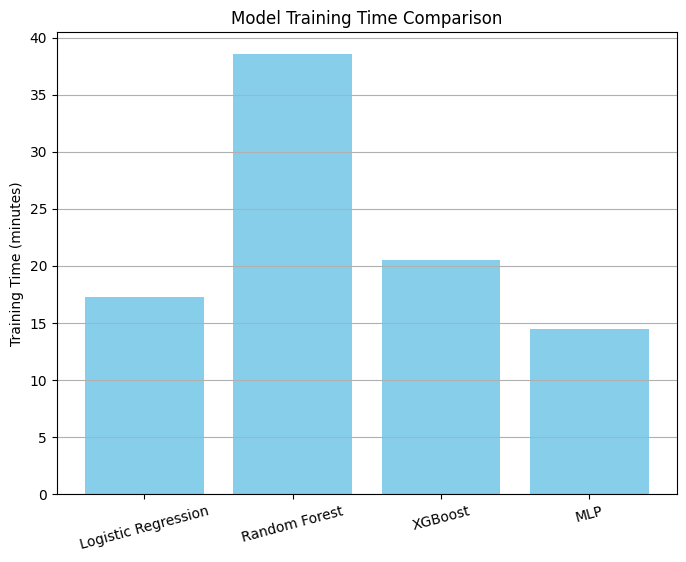

In [ ]:
# Plot the running time of the models
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'MLP']
times = [17.30, 38.54, 20.49, 14.46]

plt.figure(figsize=(8, 6))
plt.bar(models, times, color='skyblue')
plt.ylabel('Training Time (minutes)')
plt.title('Model Training Time Comparison')
plt.grid(axis='y')
plt.xticks(rotation=15)
plt.show()

Feature selection on baseline model: XGBoost

In [15]:
xgb_params = {
    'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.13,
    'max_depth': 7, 'n_estimators': 400, 'reg_alpha': 0, 'reg_lambda': 1.5,
    'scale_pos_weight': 1546.3870967741937, 'subsample': 0.7,
    'eval_metric': 'logloss', 'objective': 'binary:logistic',
    'random_state': 42, 'n_jobs': -1
}

xgb_seed = xgb.XGBClassifier(**xgb_params)
xgb_seed.fit(X_train, y_train)

importances = xgb_seed.feature_importances_
order = np.argsort(importances)[::-1]
feat_names = np.array(X_train.columns)
ranked_feats = feat_names[order]

In [16]:
def add_FE(df):
    df = df.copy()
    df['balance_diff'] = df['oldbalanceOrg'] - df['newbalanceOrig']
    df['amount_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1)
    df['balance_to_amount'] = df['newbalanceOrig'] / (df['amount'] + 1)
    return df

# Apply FE to train and val
X_train_fe = add_FE(X_train)
X_val_fe = add_FE(X_val)
X_test_fe = add_FE(X_test)


# Clean up inf/nan
for df in (X_train_fe, X_val_fe, X_test_fe):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0.0, inplace=True)

In [17]:
fe_model = xgb.XGBClassifier(**xgb_params)   # your preserved params
fe_model.fit(X_train_fe, y_train)

# Training predictions on XGBoost
y_train_fe_pred = fe_model.predict(X_train_fe)
print("Training Set Report (FE):\n", classification_report(y_train, y_train_fe_pred))

Training Set Report (FE):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    599225
           1       1.00      1.00      1.00       775

    accuracy                           1.00    600000
   macro avg       1.00      1.00      1.00    600000
weighted avg       1.00      1.00      1.00    600000



Val Set Report with custom threshold:
 0.2               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199742
           1       0.89      0.97      0.92       258

    accuracy                           1.00    200000
   macro avg       0.94      0.98      0.96    200000
weighted avg       1.00      1.00      1.00    200000



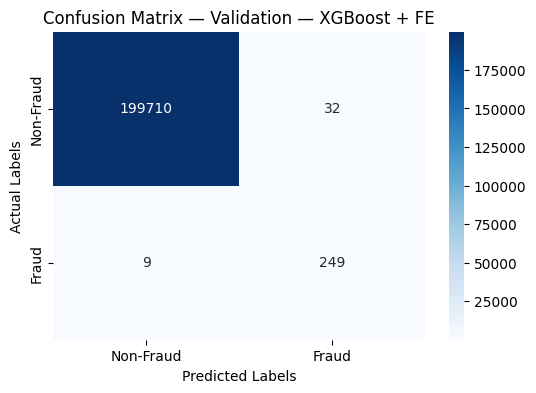

In [18]:
# Threshold from baseline
custom_threshold_fe = 0.2

# Get probabilities for the positive class
y_val_proba_fe = fe_model.predict_proba(X_val_fe)[:, 1]
y_val_pred_custom_fe = (y_val_proba_fe >= custom_threshold_fe).astype(int)

# Evaluate
print("Val Set Report with custom threshold:\n", custom_threshold_fe,
      classification_report(y_val, y_val_pred_custom_fe))

# Compute confusion matrix for validation predictions
cm_val_fe = confusion_matrix(y_val, y_val_pred_custom_fe)
plt.figure(figsize=(6,4))
sns.heatmap(cm_val_fe, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix — Validation — XGBoost + FE')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

In [19]:
# Predict on the test sets
y_test_pred_fe = fe_model.predict(X_test_fe)


Test Set Evaluation with Threshold for higher Recall = 0.2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199742
           1       0.88      0.98      0.93       258

    accuracy                           1.00    200000
   macro avg       0.94      0.99      0.96    200000
weighted avg       1.00      1.00      1.00    200000



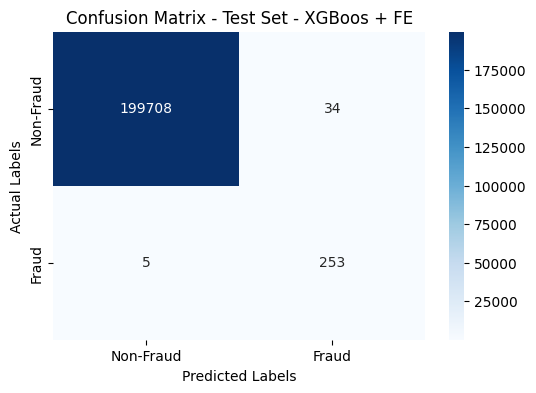

In [20]:
# Set custom threshold
custom_thres_fe = 0.2
y_test_proba_fe = fe_model.predict_proba(X_test_fe)[:, 1]
y_test_pred_fe  = (y_test_proba_fe >= custom_thres_fe).astype(int)

# Evaluate on test set
print("Test Set Evaluation with Threshold for higher Recall =", custom_thres_fe)
print(classification_report(y_test, y_test_pred_fe))
cm_test = confusion_matrix(y_test, y_test_pred_fe)
plt.figure(figsize=(6,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Test Set - XGBoos + FE')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

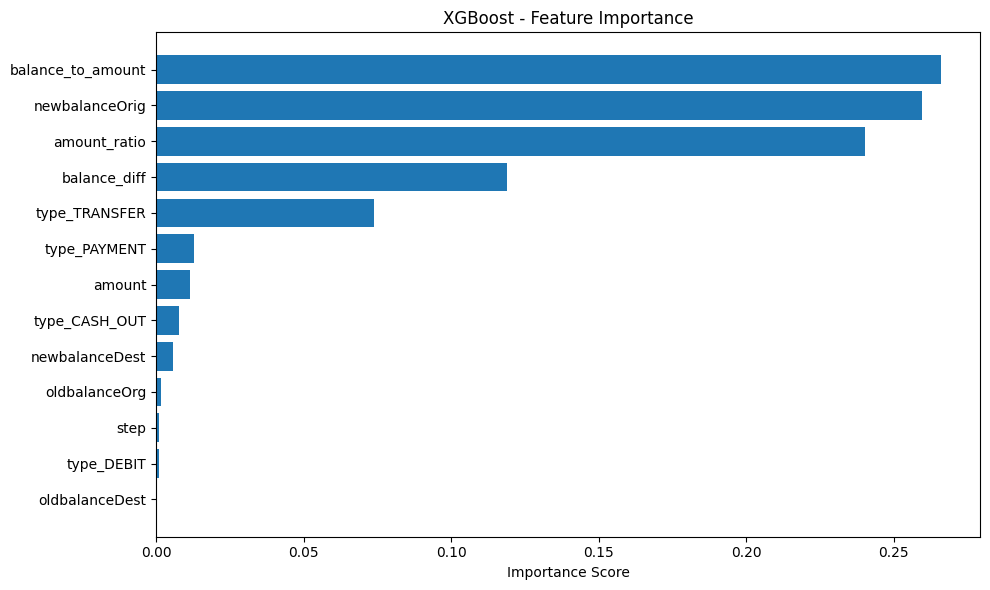

In [21]:
# Get feature importances from the model
importances_fe_xg = fe_model.feature_importances_

# Get feature names
feature_names_xg = X_train_fe.columns

# Combine into a DataFrame for easier plotting
importance_df_xg = pd.DataFrame({
    'Feature': feature_names_xg,
    'Importance': importances_fe_xg
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df_xg['Feature'], importance_df_xg['Importance'])
plt.gca().invert_yaxis()
plt.title('XGBoost - Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

LR + FE

In [22]:
best_params = {'C': 3.0, 'class_weight': 'balanced', 'max_iter': 500, 'solver': 'lbfgs'}

# Scale (LR benefits from scaling)
scaler = StandardScaler()
X_train_fe_s = scaler.fit_transform(X_train_fe)
X_val_fe_s   = scaler.transform(X_val_fe)
X_test_fe_s  = scaler.transform(X_test_fe)

# New LR model with the SAME tuned params
lr_fe = LogisticRegression(**best_params, random_state=42)
lr_fe.fit(X_train_fe_s, y_train)

LogisticRegression(C=3.0, class_weight='balanced', max_iter=500,
                   random_state=42)

In [23]:
# Fixed threshold from baseline
fixed_thr = 0.9986

# Trainig set with fix threshold from baseline
y_train_pred_fe_lr = (lr_fe.predict_proba(X_train_fe_s)[:, 1] >= fixed_thr).astype(int)
print("Training Set Report - LR + FE with threshold 0.9986:")
print(classification_report(y_train, y_train_pred_fe_lr, digits=3))

Training Set Report - LR + FE with threshold 0.9986:
              precision    recall  f1-score   support

           0      0.999     1.000     1.000    599225
           1      0.658     0.524     0.583       775

    accuracy                          0.999    600000
   macro avg      0.829     0.762     0.791    600000
weighted avg      0.999     0.999     0.999    600000



Validation Set Report - LR + FE with threshold 0.9986:
              precision    recall  f1-score   support

           0      0.999     1.000     1.000    199742
           1      0.685     0.589     0.633       258

    accuracy                          0.999    200000
   macro avg      0.842     0.794     0.816    200000
weighted avg      0.999     0.999     0.999    200000



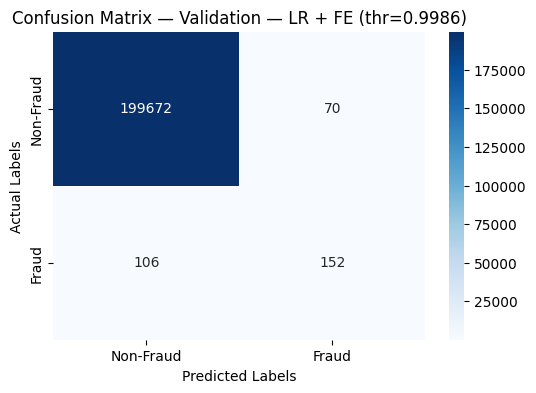

In [24]:
# Validation set
y_val_pred_fe_lr = (lr_fe.predict_proba(X_val_fe_s)[:, 1] >= fixed_thr).astype(int)
print("Validation Set Report - LR + FE with threshold 0.9986:")
print(classification_report(y_val, y_val_pred_fe_lr, digits=3))

# Confusion matrix for validation
cm_val_fe_lr = confusion_matrix(y_val, y_val_pred_fe_lr)
plt.figure(figsize=(6,4))
sns.heatmap(cm_val_fe_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix — Validation — LR + FE (thr=0.9986)')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

Test Set Evaluation with Threshold from Baseline LR = 0.9986
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199742
           1       0.67      0.56      0.61       258

    accuracy                           1.00    200000
   macro avg       0.84      0.78      0.81    200000
weighted avg       1.00      1.00      1.00    200000



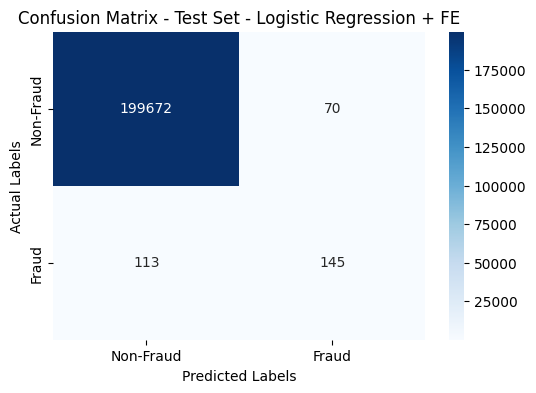

In [25]:
# Test set
y_test_proba_fe_lr = lr_fe.predict_proba(X_test_fe_s)[:, 1]  # scaled FE test data
y_test_pred_fe_lr = (y_test_proba_fe_lr >= fixed_thr).astype(int)

# Evaluate on test set
print("Test Set Evaluation with Threshold from Baseline LR =", fixed_thr)
print(classification_report(y_test, y_test_pred_fe_lr))
cm_test_fe_lr = confusion_matrix(y_test, y_test_pred_fe_lr)
plt.figure(figsize=(6,4))
sns.heatmap(cm_test_fe_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Test Set - Logistic Regression + FE')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

Top 10 Features (LR + FE, absolute coefficient magnitude):
              Feature  Importance
5      newbalanceDest   47.095654
4      oldbalanceDest   43.176217
6       type_CASH_OUT   22.447730
9       type_TRANSFER   13.490169
11       amount_ratio   11.638432
8        type_PAYMENT   10.735713
12  balance_to_amount    5.739310
10       balance_diff    3.536236
7          type_DEBIT    1.600470
0                step    0.393590


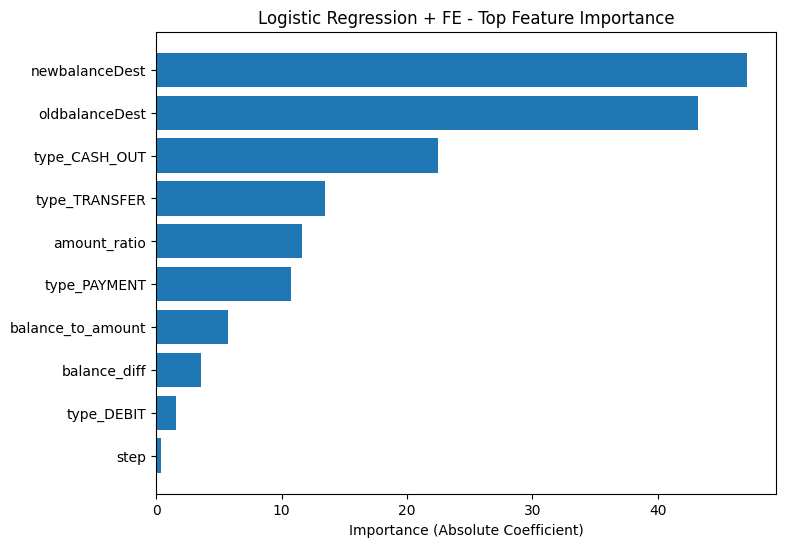

In [26]:
# Get coefficients from LR + FE model
coefficients_fe = lr_fe.coef_[0]

# Absolute values for magnitude ranking
importances_fe = np.abs(coefficients_fe)

# Feature names come from the FE training set
features_fe = X_train_fe.columns

# Create DataFrame and sort by importance
importance_df_fe = (
    pd.DataFrame({
        'Feature': features_fe,
        'Importance': importances_fe
    }).sort_values(by='Importance', ascending=False)
)

# Show top 10
print("Top 10 Features (LR + FE, absolute coefficient magnitude):")
print(importance_df_fe.head(10))

# Plot top 10
topN = 10
plt.figure(figsize=(8, 6))
plt.barh(
    importance_df_fe['Feature'].head(topN)[::-1],
    importance_df_fe['Importance'].head(topN)[::-1]
)
plt.xlabel('Importance (Absolute Coefficient)')
plt.title('Logistic Regression + FE - Top Feature Importance')
plt.show()



Random Forest + FE


In [27]:
rf_params = {
    "n_estimators": 100,
    "max_depth": 20,
    "max_features": "sqrt",
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "class_weight": "balanced",
    "random_state": 42,
    "n_jobs": -1
}
rf_fe = RandomForestClassifier(**rf_params)
rf_fe.fit(X_train_fe, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, n_jobs=-1,
                       random_state=42)

Validation Set — Random Forest + FE with baseline threshold 0.2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199742
           1       0.99      1.00      1.00       258

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



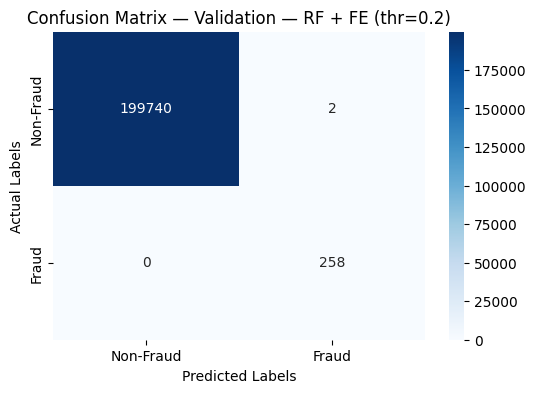

In [28]:
# Fixed threshold
fixed_thr_rf = 0.2

# Validation performance at the fixed threshold
val_proba_fe_rf = rf_fe.predict_proba(X_val_fe)[:, 1]
y_val_pred_fe_rf = (val_proba_fe_rf >= fixed_thr_rf).astype(int)
print("Validation Set — Random Forest + FE with baseline threshold 0.2")
print(classification_report(y_val, y_val_pred_fe_rf))

# Confusion matrix
cm_val_fe_rf = confusion_matrix(y_val, y_val_pred_fe_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_val_fe_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title(f'Confusion Matrix — Validation — RF + FE (thr={fixed_thr_rf})')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()


Test Set — Random Forest + FE with baseline threshold 0.2
              precision    recall  f1-score   support

           0      1.000     1.000     1.000    199742
           1      0.996     0.992     0.994       258

    accuracy                          1.000    200000
   macro avg      0.998     0.996     0.997    200000
weighted avg      1.000     1.000     1.000    200000



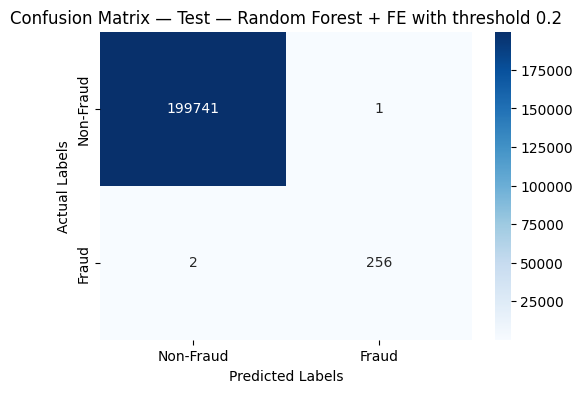

In [29]:
# Test evaluation
test_proba_fe_rf = rf_fe.predict_proba(X_test_fe)[:, 1]
y_test_pred_fe_rf = (test_proba_fe_rf >= fixed_thr_rf).astype(int)

print("\nTest Set — Random Forest + FE with baseline threshold 0.2")
print(classification_report(y_test, y_test_pred_fe_rf, digits=3))

cm_test = confusion_matrix(y_test, y_test_pred_fe_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix — Test — Random Forest + FE with threshold 0.2')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

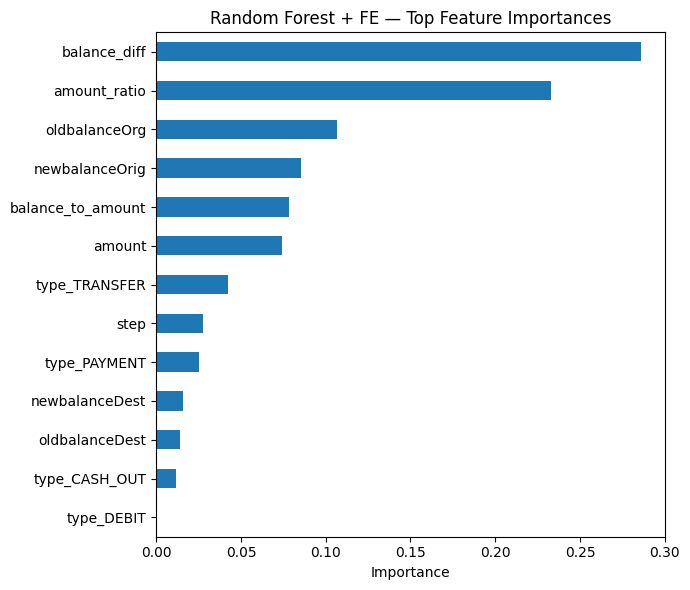

In [30]:
# Top feature importances
importances = pd.Series(rf_fe.feature_importances_, index=X_train_fe.columns).sort_values(ascending=False)
plt.figure(figsize=(7,6))
importances.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Random Forest + FE — Top Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

MLP + Fe

In [31]:
# MLP (architecture & hyperparams as baseline)

n_in = X_train_fe_s.shape[1]

model_fe_mlp = Sequential([
    Input(shape=(n_in,)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model_fe_mlp.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='pr_auc', curve='PR'),
    ],
)

early_stop = EarlyStopping(monitor='val_pr_auc', mode='max', patience=10, restore_best_weights=True)

# Same class weights as your baseline training
baseline_class_weights = {0: 1, 1: 100}

history = model_fe_mlp.fit(
    X_train_fe_s, y_train,
    validation_data=(X_val_fe_s, y_val),
    epochs=50,
    batch_size=256,
    class_weight=baseline_class_weights,
    callbacks=[early_stop],
    verbose=1,
)

Epoch 1/50
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.2041 - pr_auc: 0.2877 - precision: 0.0290 - recall: 0.6714 - val_loss: 0.0217 - val_pr_auc: 0.6698 - val_precision: 0.1687 - val_recall: 0.8140
Epoch 2/50
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1021 - pr_auc: 0.4742 - precision: 0.0720 - recall: 0.8125 - val_loss: 0.0344 - val_pr_auc: 0.6798 - val_precision: 0.0888 - val_recall: 0.8876
Epoch 3/50
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0826 - pr_auc: 0.5543 - precision: 0.0885 - recall: 0.8586 - val_loss: 0.0311 - val_pr_auc: 0.7450 - val_precision: 0.1640 - val_recall: 0.8876
Epoch 4/50
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0810 - pr_auc: 0.5073 - precision: 0.0869 - recall: 0.8607 - val_loss: 0.0252 - val_pr_auc: 0.7505 - val_precision: 0.1396 - val_recall: 0.8953
Epoch 5/50
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0692 - pr_auc: 0.5705 - precision: 0.0913 - recall: 0.8555 - val_loss: 0.0274 - val_pr_auc: 0.7775 - va

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Validation Metrics — MLP + FE with fixed 0.5
              precision    recall  f1-score   support

           0      1.000     0.999     0.999    199742
           1      0.475     0.903     0.622       258

    accuracy                          0.999    200000
   macro avg      0.737     0.951     0.811    200000
weighted avg      0.999     0.999     0.999    200000



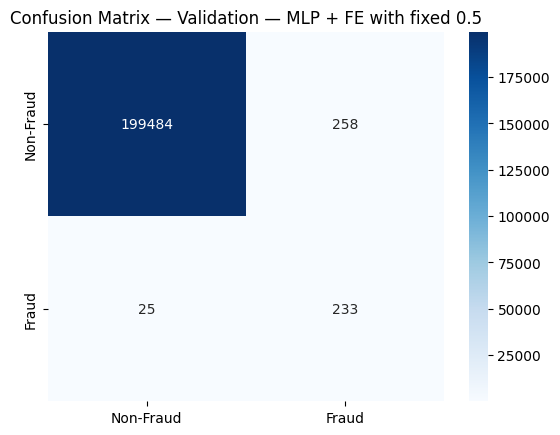

In [32]:
# Predict on validation set
y_val_proba_fe_mlp = model_fe_mlp.predict(X_val_fe_s).flatten()
y_val_pred_fe_mlp = (y_val_proba_fe_mlp >= 0.5).astype(int)

print("Validation Metrics — MLP + FE with fixed 0.5")
print(classification_report(y_val, y_val_pred_fe_mlp, digits=3))

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred_fe_mlp)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud','Fraud'],
            yticklabels=['Non-Fraud','Fraud'])
plt.title("Confusion Matrix — Validation — MLP + FE with fixed 0.5")
plt.show()


Test — MLP + FE with fixed threshold 0.5
              precision    recall  f1-score   support

           0      1.000     0.999     0.999    199742
           1      0.479     0.860     0.616       258

    accuracy                          0.999    200000
   macro avg      0.740     0.930     0.808    200000
weighted avg      0.999     0.999     0.999    200000



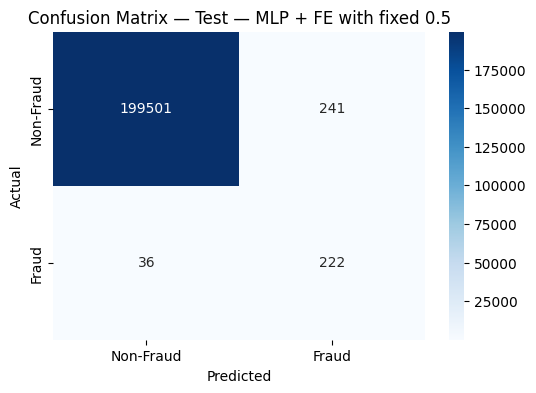

In [33]:
# Evaluate at fixed threshold 0.5 from baseline model
fixed_thr_mlp = 0.5
y_test_proba_fe_mlp = model_fe_mlp.predict(X_test_fe_s, verbose=0).ravel()
y_test_pred_fe_mlp  = (y_test_proba_fe_mlp >= fixed_thr_mlp).astype(int)

print("Test — MLP + FE with fixed threshold 0.5")
print(classification_report(y_test, y_test_pred_fe_mlp, digits=3))

cm = confusion_matrix(y_test, y_test_pred_fe_mlp)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud','Fraud'],
            yticklabels=['Non-Fraud','Fraud'])
plt.title('Confusion Matrix — Test — MLP + FE with fixed 0.5')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


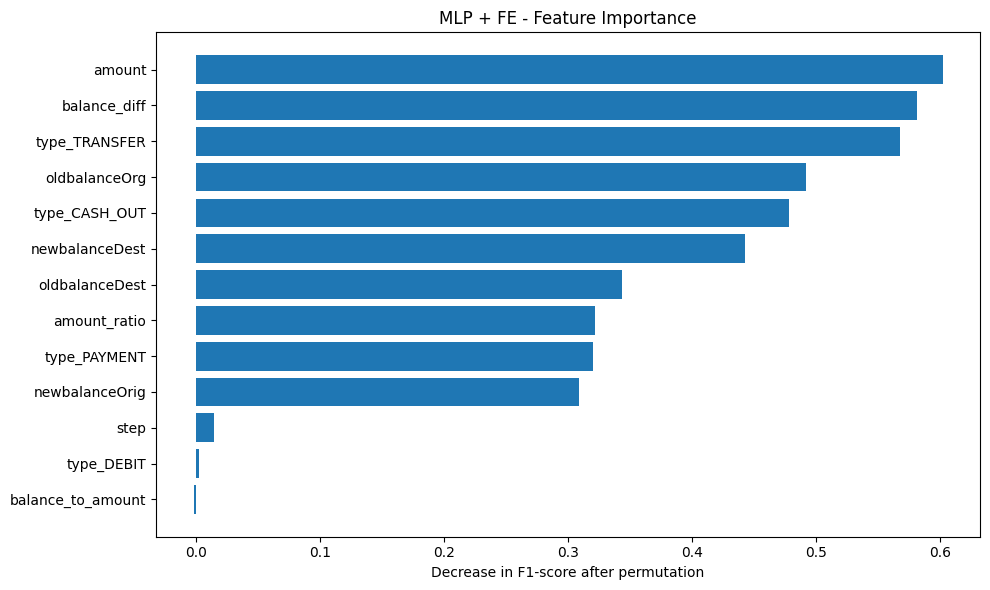

In [35]:
# Get baseline F1-score on validation set
y_val_pred_fe_mlp = (model_fe_mlp.predict(X_val_fe_s).flatten() >= 0.5).astype(int)
baseline_f1_fe = f1_score(y_val, y_val_pred_fe_mlp)

# Run permutation importance manually
importances_fe = []
feature_names_fe = X_train_fe.columns

for i in range(X_val_fe_s.shape[1]):
    X_val_permuted_fe = X_val_fe_s.copy()
    np.random.shuffle(X_val_permuted_fe[:, i])  # Shuffle one feature column
    y_val_pred_perm_fe = (model_fe_mlp.predict(X_val_permuted_fe).flatten() >= 0.5).astype(int)
    permuted_f1_fe = f1_score(y_val, y_val_pred_perm_fe)
    importance = baseline_f1_fe - permuted_f1_fe
    importances_fe.append(importance)

# Convert to numpy array and sort
importances_fe = np.array(importances_fe)
sorted_idx_fe = np.argsort(importances_fe)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx_fe)), importances_fe[sorted_idx_fe])
plt.yticks(range(len(sorted_idx_fe)), feature_names_fe[sorted_idx_fe])
plt.xlabel("Decrease in F1-score after permutation")
plt.title("MLP + FE - Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()